In [1]:
# !pip install tensorflow-addons-0.21.0
!pip install tensorflow-addons[tensorflow]

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic


In [2]:
import logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Fallback in case the following line doesn't work
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Reshape, MaxPooling2D, LSTM, Dense, Flatten, concatenate
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import mixed_precision
from keras.layers import Dropout, BatchNormalization
from keras.regularizers import l2
import time
from PIL import Image
import pandas as pd
import h5py
from tensorflow.keras.callbacks import EarlyStopping
import keras
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import Precision, Recall

In [3]:
# Parameters
height = 64
width = 64
num_classes = 3
window_size = 30 * 60

# Define the number of batches
train_num_batches = 21
test_num_batches = 9
batch_size = 256
grad_accum_steps = 2  # define your gradient accumulation steps

# Set up mixed precision training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


In [4]:
# Check GPUs available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


4 Physical GPUs, 4 Logical GPUs


In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  4


In [6]:
import psutil

# Gives a human-readable format of bytes
def bytes_to_gb(bytes):
    return bytes / 1024 / 1024 / 1024

total_memory_gb = bytes_to_gb(psutil.virtual_memory().total)

print(f'Total memory: {total_memory_gb} GB')


Total memory: 187.52114486694336 GB


In [15]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, participant_ids, window_size, is_train=True):
        self.participant_ids = participant_ids
        self.window_size = window_size
        self.is_train = is_train
        self.data_file = h5py.File('data.hdf5', 'r')
        self.windows = self._generate_windows()
        self.total_windows = len(self.windows)
        self.total_frames = self._calculate_total_frames
        self.counter = 0

        print(f"Total number of windows generated: {self.total_windows}")
        print(f"Total number of frames: {self.total_frames}")

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]

        participant_id, start_idx, end_idx = window

        X_left, X_right, y = self._load_data(participant_id, start_idx, end_idx)
        # Reshape the data
        X_left = X_left.reshape(self.window_size, 64, 64, 1)  
        X_right = X_right.reshape(self.window_size, 64, 64, 1)  
        y = y.reshape(self.window_size, -1) 
        y = to_categorical(y, num_classes=3)
        
        # print(f"Shapes after reshaping: {X_left.shape}, {X_right.shape}, {y.shape}")
        return [np.array([X_left]), np.array([X_right])], np.array([y])

        
# undersampling the majority class
    # def _generate_windows(self):
    #     windows = []
    #     majority_windows = []
    
    #     for participant_id in self.participant_ids:
    #         X_left = self.data_file[f'{participant_id}/left_eye']
    #         num_frames = len(X_left)
    #         num_windows = num_frames // self.window_size
    
    #         for i in range(num_windows):
    #             start_idx = i * self.window_size
    #             end_idx = start_idx + self.window_size
    #             y = self.data_file[f'{participant_id}/labels'][start_idx]
    
    #             # Label the window
    #             is_majority_window = (y == 0)  # Adjusted for one-hot encoding
    
    #             window = (participant_id, start_idx, end_idx)
    #             if is_majority_window:
    #                 majority_windows.append(window)
    #             else:
    #                 windows.append(window)
    
    #     # Sample windows from the majority class
    #     n_minority = len(windows)
    #     majority_indices = np.random.choice(len(majority_windows), n_minority, replace=False)
    #     majority_windows = np.array(majority_windows)[majority_indices].tolist()
    
    #     # Combine the lists
    #     windows += majority_windows
    
    #     # Shuffle the windows to mix the classes
    #     np.random.shuffle(windows)
    
    #     return windows

        
    def _generate_windows(self):
        windows = []
        for participant_id in self.participant_ids:
            X_left = self.data_file[f'{participant_id}/left_eye']
            num_frames = len(X_left)
            num_windows = num_frames // self.window_size
            for i in range(num_windows):
                start_idx = i * self.window_size
                end_idx = start_idx + self.window_size
                windows.append((participant_id, start_idx, end_idx))
                
                #Uncomment if you want to use padding for the rest of the frames
    
            # remaining_frames = num_frames % self.window_size
            # if remaining_frames > 0:
            #     # Create a window for the remaining frames
            #     start_idx = num_frames - remaining_frames
            #     end_idx = num_frames
            #     windows.append((participant_id, start_idx, end_idx))
        return windows


    def _load_data(self, participant_id, start_idx, end_idx):
        X_left = self.data_file[f'{participant_id}/left_eye'][start_idx:end_idx]
        X_right = self.data_file[f'{participant_id}/right_eye'][start_idx:end_idx]
        y = self.data_file[f'{participant_id}/labels'][start_idx:end_idx]
    
        #Uncomment if you want to use padding for the rest of the frames
        # while len(X_left) < self.window_size:  # pad if not enough frames
        #     X_left = np.concatenate([X_left, X_left], axis=0)
        #     X_right = np.concatenate([X_right, X_right], axis=0)
        #     y = np.concatenate([y, y], axis=0)

        # In case the duplication exceeds the window size, slice it back.
        X_left = X_left[:self.window_size]
        X_right = X_right[:self.window_size]
        y = y[:self.window_size]
        return X_left, X_right, y


    def _calculate_total_frames(self):
        total_frames = 0
        for participant_id in self.participant_ids:
            X_left = self.data_file[f'{participant_id}/left_eye']
            total_frames += len(X_left)
            #print(f"Participant {participant_id} has {len(X_left)} frames")  # Added print statement
        return total_frames


In [17]:
#Create a list of participant IDs. Replace this with your actual participant IDs.
train_participant_ids = range(1,25)
test_participant_ids = range(25,31)
# Create an instance of the DataGenerator
window_size = 1800  # Replace with your actual window size
# Initialize the data generators.
train_data_generator = DataGenerator(train_participant_ids, window_size)#, batch_size)
test_data_generator = DataGenerator(test_participant_ids, window_size)#, batch_size)


Total number of windows generated:  2195
Total number of frames: <bound method DataGenerator._calculate_total_frames of <__main__.DataGenerator object at 0x2ab3cdb440a0>>
Total number of windows generated: 541
Total number of frames: <bound method DataGenerator._calculate_total_frames of <__main__.DataGenerator object at 0x2ab43aa7b3a0>>


In [18]:
# Define an input sequence and process it.
left_eye_input = Input(shape=(None, 64, 64, 1))
right_eye_input = Input(shape=(None, 64, 64, 1))
latent_dim = 64
# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
def create_eye_model(input_layer):
    eye_model = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))(input_layer)  # Reduced number of filters
    eye_model = TimeDistributed(BatchNormalization())(eye_model)
    eye_model = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(eye_model)
    eye_model = TimeDistributed(Dropout(0.25))(eye_model)
    eye_model = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))(eye_model)  # Reduced number of filters
    eye_model = TimeDistributed(BatchNormalization())(eye_model)
    eye_model = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(eye_model)
    eye_model = TimeDistributed(Dropout(0.25))(eye_model)
    eye_model = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))(eye_model)  # Reduced number of filters
    eye_model = TimeDistributed(BatchNormalization())(eye_model)
    eye_model = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(eye_model)
    eye_model = TimeDistributed(Dropout(0.25))(eye_model)
    eye_model = TimeDistributed(Conv2D(126, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)))(eye_model)  # Reduced number of filters
    eye_model = TimeDistributed(BatchNormalization())(eye_model)
    eye_model = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(eye_model)
    eye_model = TimeDistributed(Dropout(0.25))(eye_model)
    return TimeDistributed(Flatten())(eye_model)

# Create models for each eye
left_eye_model = create_eye_model(left_eye_input)
right_eye_model = create_eye_model(right_eye_input)
       
# Concatenate the outputs of left and right eye models
concatenated = Concatenate()([left_eye_model, right_eye_model])
# print(concatenated.shape)
   
# Increase LSTM units and add another LSTM layer
encoder_lstm = LSTM(128, return_sequences=True, return_state=True, dropout=0.25)
encoder_outputs, state_h, state_c = encoder_lstm(concatenated)
encoder_states = [state_h, state_c]
      
encoder_lstm_2 = LSTM(128, return_sequences=True, return_state=True, dropout=0.25)
encoder_outputs_2, state_h_2, state_c_2 = encoder_lstm_2(encoder_outputs)
encoder_states_2 = [state_h_2, state_c_2]
        
encoder_lstm_3 = LSTM(128, return_sequences=True, return_state=True, dropout=0.25)
encoder_outputs_3, state_h_3, state_c_3 = encoder_lstm_3(encoder_outputs_2)
encoder_states_3 = [state_h_3, state_c_3]
       
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = RepeatVector(window_size)(encoder_states_3[0])  # Repeat the encoder output for each time step of the output
decoder_lstm = LSTM(128, return_sequences=True, dropout=0.2)  # Adding dropout to LSTM
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states_3)
decoder_dense = TimeDistributed(Dense(num_classes, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)
        
# Define the model
model = Model([left_eye_input, right_eye_input], decoder_outputs)
        
# Compile the model

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adamax(learning_rate=lr_schedule)


loss_fn = tf.keras.losses.CategoricalCrossentropy()
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

#early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Save the model after each epoch
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', verbose=0.1, monitor='val_loss', save_best_only=True, mode='auto')

# Stop training when the validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0.1)

# Train the model

history = model.fit(train_data_generator, 
                    steps_per_epoch=len(train_data_generator), 
                    epochs=100, 
                    callbacks=[checkpoint, early_stopping], 
                    verbose=1, 
                    validation_data=test_data_generator, 
                    validation_steps=len(test_data_generator))  

Epoch 1/100
2195/2195 [==============================] - ETA: 0s - loss: 0.8527 - accuracy: 0.6763 - precision_2: 0.6773 - recall_2: 0.6709
Epoch 1: val_loss improved from inf to 0.62144, saving model to model-001.h5
2195/2195 [==============================] - 737s 330ms/step - loss: 0.8527 - accuracy: 0.6763 - precision_2: 0.6773 - recall_2: 0.6709 - val_loss: 0.6214 - val_accuracy: 0.9002 - val_precision_2: 0.9002 - val_recall_2: 0.9002
Epoch 2/100
2195/2195 [==============================] - ETA: 0s - loss: 0.8147 - accuracy: 0.6791 - precision_2: 0.6791 - recall_2: 0.6791
Epoch 2: val_loss improved from 0.62144 to 0.52829, saving model to model-002.h5
2195/2195 [==============================] - 705s 321ms/step - loss: 0.8147 - accuracy: 0.6791 - precision_2: 0.6791 - recall_2: 0.6791 - val_loss: 0.5283 - val_accuracy: 0.9002 - val_precision_2: 0.9002 - val_recall_2: 0.9002
Epoch 3/100
2195/2195 [==============================] - ETA: 0s - loss: 0.8138 - accuracy: 0.6791 - precisi

In [19]:
# test_data_generator = DataGenerator(test_participant_ids, window_size)

# Evaluate the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data_generator, steps=len(test_data_generator))
# , test_f1_score
print(f"Test accuracy: {test_accuracy}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test loss: {test_loss}")

541/541 [==============================] - 63s 115ms/step - loss: 0.5049 - accuracy: 0.9002 - precision_2: 0.9002 - recall_2: 0.9002
Test accuracy: 0.900165319442749
Test precision: 0.900165319442749
Test recall: 0.900165319442749
Test loss: 0.5049018263816833


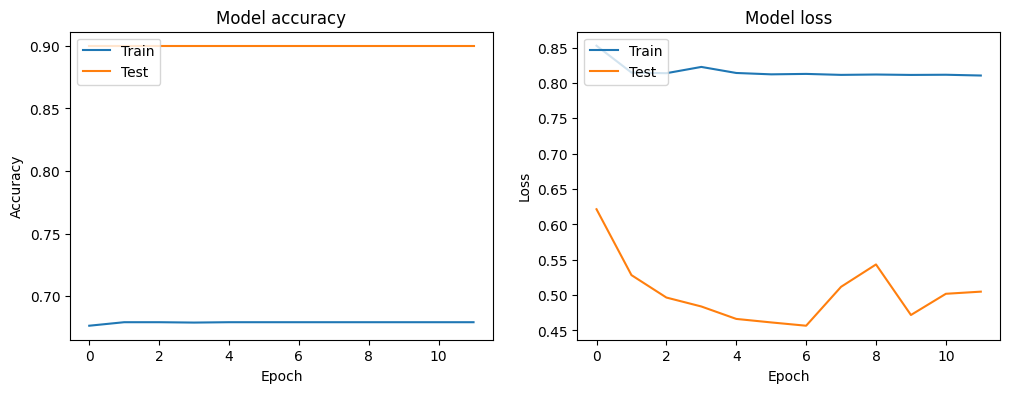

KeyError: 'precision'

<Figure size 1200x400 with 0 Axes>

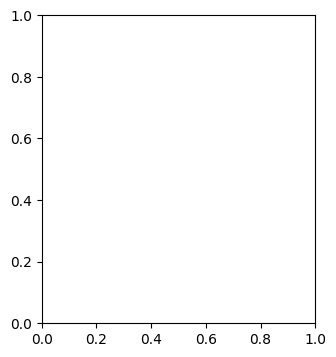

In [20]:
# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

# Plot precision, recall, F1 score
plt.figure(figsize=(12, 4))

# Plot precision, recall, F1 score
plt.figure(figsize=(12, 4))

# Precision
plt.subplot(1, 3, 1)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Recall
plt.subplot(1, 3, 2)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
# F1 Score
# plt.subplot(1, 3, 3)
# plt.plot(history.history['f1_score'])
# plt.plot(history.history['val_f1_score'])
# plt.title('Model F1 Score')
# plt.ylabel('F1 Score')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

Confusion Matrix:
[[876581      0      0]
 [ 84637      0      0]
 [ 12582      0      0]]


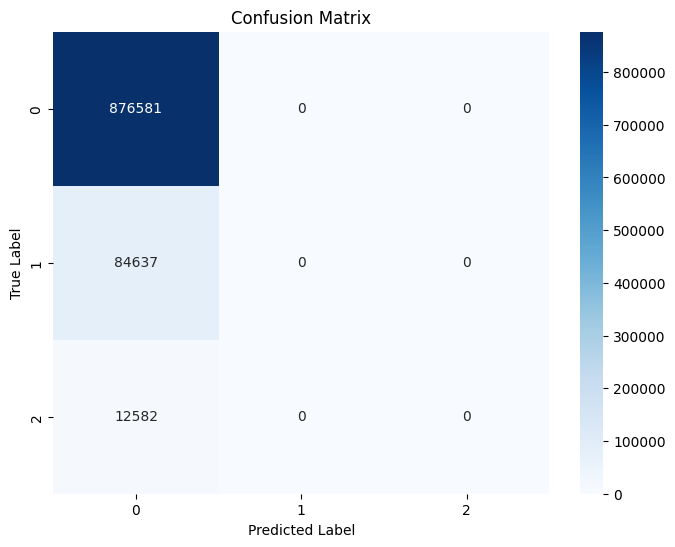

In [22]:
# !pip install seaborn
# !pip install sklearn
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# Generate the confusion matrix using the test data generator
y_true = []
y_pred = []

for i in range(len(test_data_generator)):
    (X_test_left, X_test_right), y_test = test_data_generator[i]
    # Make predictions on the current batch
    probabilities = model.predict([X_test_left, X_test_right])
    predictions = np.argmax(probabilities, axis=-1)
    # Reshape the labels and predictions
    y_test = np.argmax(y_test, axis=-1).flatten()
    predictions = predictions.flatten()
    # Extend the true and predicted labels
    y_true.extend(y_test)
    y_pred.extend(predictions)

# Convert y_true and y_pred to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Get indices where y_true or y_pred is 1 or 2
indices = np.where((y_true == 1) | (y_true == 2) | (y_pred == 1) | (y_pred == 2))

# Filter y_true and y_pred using these indices
y_true_filtered = y_true[indices]
y_pred_filtered = y_pred[indices]

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [18]:
#to check how many sections of frames are for each label
labels = []
for i in range(len(train_data_generator)):
    (_, _), batch_labels = train_data_generator[i]
    labels.extend(batch_labels)

label_counts = {
    "[1, 0, 0]": sum((label == [1, 0, 0]).all() for label in labels),
    "[0, 1, 0]": sum((label == [0, 1, 0]).all() for label in labels),
    "[0, 0, 1]": sum((label == [0, 0, 1]).all() for label in labels)
}

print("Label Counts:")
for label, count in label_counts.items():
    print(label, ":", count)


Label Counts:
[1, 0, 0] : 1416
[0, 1, 0] : 396
[0, 0, 1] : 116
